# Walkthrough of pattern completion simulation

This pattern completion simulation is based on the simulation done in the paper [Synaptic mechanisms
of pattern completion in the hippocampal CA3 network](http://science.sciencemag.org/content/353/6304/1117) by Guzman, Schlogl, Frotscher, and Jonas (2016). 

A high-level explanation of how this simulation works is found in this notebook. Further explanation, along with experimental results, can be found in the accompanying report, Explaining and Exploring Pattern Completion, found in this github repository. 

In [2]:
import numpy as np
import numpy.random as npr
from scipy import sparse
from scipy.spatial.distance import cosine
from time import time

from matplotlib import pyplot as plt
from matplotlib import animation, rc, collections
from IPython.display import HTML

np.set_printoptions(precision=3)

The first thing we will do is a create the underlying random connectivity matrix, which defines how the neurons can be connected to each other. This simulation works with network size of 100,000 neurons, though in Guzman et. al. they focus on 330,000.

Depending on the value of p, which defines how many neurons should be connected, this matrix can be created in a couple minutes. It is the slowest part of the simulation, but operations with the matrix will be much faster. (Note the use of sparse matrices, which is necessary for working with matrices of this size.)

In [3]:
def get_weights_rand(shape, prob):
    """Return a weights matrix with prob amount of random connections activated.
    
    Args:
        shape: (int) number of neurons in network
        prob: (float) fraction of connections to be activated
    
    Returns:
        weights: (numpy matrix) connectivity weight matrix
    """
    # This is not quite totally randomly, but good enough for our purposes
    l = int(shape*shape*prob)
    rows = npr.choice(range(shape), l)
    cols = npr.choice(range(shape), l)
    weights = sparse.csr_matrix((np.ones(l), (rows, cols)), shape=(shape,shape))
    weights.setdiag(0)
    return weights

n = 100000                 # number of neurons in network; CA3 is 330,000 (or double)
p = .03                    # connection probability for weight matrix

now = time()
W = get_weights_rand(n, p) # connectivity weight matrix; are neurons connected?
print('made W in', time() - now)
W.shape

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


made W in 175.12145590782166


(100000, 100000)

Now we will create the patterns and the synaptic connectivity matrix J, which is the connectivity matrix that has 'learned' the patterns we created. 

Patterns are binary vectors of length n which indicate which neurons are activated in a given pattern. 

J is learned using clipped Hebbian plasticity, which amounts to summing the outer dot product of all the patterns, and then clipping all values to a maximum of 1. J is a binary, symmetric matrix of size n by n.

Finally, we multiply J by W element-wise, which amounts to ensuring only the connections originally available in the W matrix are learned.

In [4]:
def get_patterns(activity, num_neurons, num_patterns):
    """Return a matrix where each row is a pattern with activity level activity.
    
    Args:
        activity: (float) avg activity level per pattern
        num_neurons: (int) num neurons in network
        num_patterns: (int) num patterns to generate
    
    Returns:
        patterns: (numpy matrix) set of patterns shape=(num_patterns, num_neurons)
    """
    return npr.binomial(1, activity, size=(num_patterns, num_neurons))

def get_syn_weights(patterns):
    """Return synaptic weight matrix.
    
    Args:
        patterns: (numpy matrix) set of patterns, shape=(num_patterns, num_neurons)
        
    Returns:
        syn: (numpy matrix) synaptic weight matrix, shape=(num_neurons, num_neurons)
    """
    num_patterns, num_neurons = patterns.shape
    row_ind = []
    col_ind = []
    for i in range(num_patterns):
        p = sparse.csr_matrix(patterns[i, :])
        mat = p.multiply(p.T)
        rows, cols = np.nonzero(mat)
        row_ind = np.concatenate([row_ind, rows])
        col_ind = np.concatenate([col_ind, cols])
    o = np.ones(len(row_ind))
    return sparse.csr_matrix((o, (row_ind, col_ind)), shape=(num_neurons, num_neurons))

m = 2                      # number of patterns to store
f = 0.001                  # average activity level of each pattern

M = get_patterns(f, n, m)  # patterns
J = get_syn_weights(M)     # synaptic weight matrix J; how much are neurons connected?
W_J = W.multiply(J)

M.shape, J.shape, W_J.shape

((2, 100000), (100000, 100000), (100000, 100000))

Now for the fun part! Let's plot the synaptic connection matrix, W \* J, to see all the connections in the simulation. We'll do this by placing all 100,000 neurons on the edge of a circle, and drawing lines between any neurons that are connected in W * J.

num connections: 610


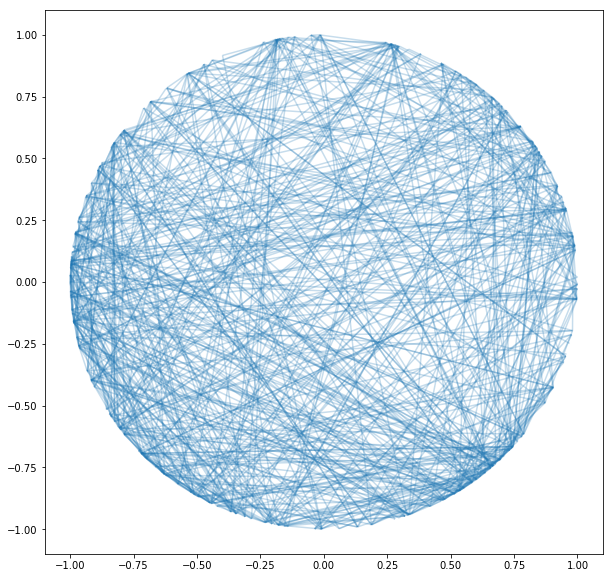

<Figure size 432x288 with 0 Axes>

In [9]:
mat = W_J

rows, cols = mat.nonzero()
all_num = np.unique(rows+cols)
print('num connections:', len(all_num))

fig, ax = plt.subplots()
fig.set_size_inches(10,10)

lines = [[(np.cos(r),np.sin(r)), (np.cos(c),np.sin(c))] for r, c in zip(rows, cols)]
lc = collections.LineCollection(lines, alpha=0.25)

ax.add_collection(lc)
ax.autoscale()
ax.margins(0.05)

plt.show()
plt.clf()

Now let's plot a pattern we created, and the connections it would light up. Similar to above, all neurons are placed on the edge of the circle, but this time we'll actually plot the neurons that are in the pattern, and we'll plot the edges that would be activated in our connectivity matrix W * J.

Note that has we not multiplied J by W, every neuron in the pattern would be connected to every other neuron. By instead using W \* J, many of these connections are removed as they didn't happen to be included in W, which is connected randomly.

You can prove this to yourself by recreating this plot with J instead of W\_J; the plot should look almost entirely filled in with connections.

num connections: 308
num nodes: 109


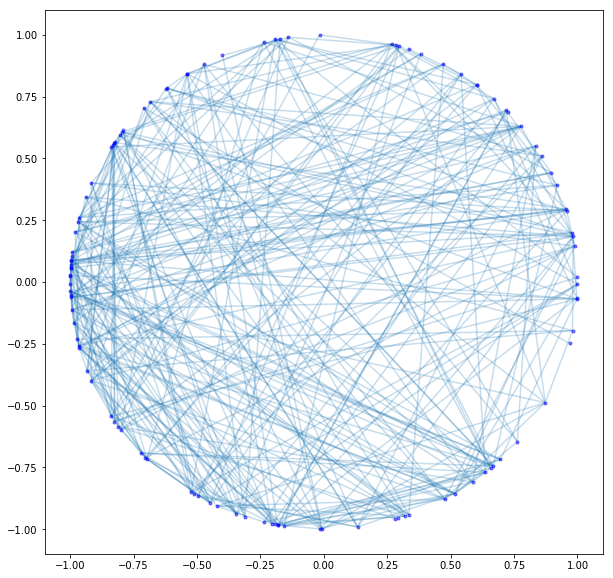

<Figure size 432x288 with 0 Axes>

In [7]:
def show_mat_and_pat(mat, pattern, outer_pattern=[]):
    rows, cols = mat.nonzero()
    all_num = np.unique(rows+cols)
    print('num connections:', len(all_num))
    print('num nodes:', len(pattern.nonzero()[0]))

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)

    lines = [[(np.cos(r),np.sin(r)), (np.cos(c),np.sin(c))] for r, c in zip(rows, cols)]
    lc = collections.LineCollection(lines, alpha=0.25)

    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.05)

    dots = pattern.nonzero()
    ax.plot(np.cos(dots), np.sin(dots), 'b.', alpha=0.5)
    
    if len(outer_pattern) > 0:
        dots = outer_pattern.nonzero()
        ax.plot(1.05*np.cos(dots), 1.05*np.sin(dots), 'g.')

    plt.show()
    plt.clf()

pattern = M[0,:]
mat = W_J.multiply(pattern)
show_mat_and_pat(mat, pattern)

Now let's degrade a pattern by removing some fraction of it neurons and adding some fraction of neurons not in it originally. We'll plot this by showing the original pattern as green dots and the degraded pattern as blue dots. Like above, we'll plot the connections that the *degraded* pattern activates.

original pattern of len 100000 with 109 fires
deg_fires: 54
nonfires: 99891
spur_fires: 49
correlation between original and degraded: 0.509118202538
num connections: 149
num nodes: 103


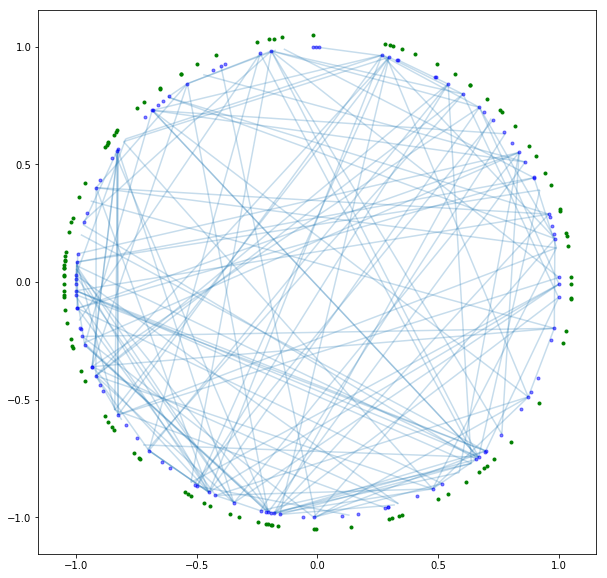

<Figure size 432x288 with 0 Axes>

In [11]:
def get_degraded_pattern(pattern, valid, spurious):
    """Return degraded pattern for input to simulation to do pattern completion.
    
    Args:
        pattern: (array) pattern to degrade, 0s or 1s, shape=(num_neurons)
        valid: (float) fraction of valid firing neurons
        spurious: (float) fraction of spurious firing neurons
    
    Return:
        deg_pat: (array) degraded pattern, 0s or 1s, shape=(num_neurons)
    """
    print('original pattern of len {} with {} fires'.format(len(pattern), sum(pattern)))
    fires = np.nonzero(pattern)[0]
    deg_fires = npr.choice(fires, size=int(valid*len(fires)), replace=False)
    print('deg_fires:', len(deg_fires))

    nonfires = np.where(pattern == 0)[0]
    spur_fires = npr.choice(nonfires, size=int(spurious*len(nonfires)), replace=False)
    print('nonfires:', len(nonfires))
    print('spur_fires:', len(spur_fires))
    
    all_fires = np.concatenate((deg_fires, spur_fires), axis=0)

    deg_pat = np.zeros(shape=(len(pattern),))
    deg_pat[all_fires] = 1
    
    return deg_pat

def get_correlation(p1, p2):
    p1_ = p1 - (sum(p1)/len(p1))
    p2_ = p2 - (sum(p2)/len(p2))
    return 1 - cosine(p1_, p2_)

b_vald = .5  # fraction of valid firing neurons in patterns
b_spur = 0.0005  # fraction of spurious firing neurons in patterns

pattern = M[0, :]
badpat = get_degraded_pattern(pattern, b_vald, b_spur)
print('correlation between original and degraded:', get_correlation(pattern, badpat))

mat = W_J.multiply(badpat)
show_mat_and_pat(mat, badpat, outer_pattern=pattern)

Almost done! Now let's run an actual simulation. We'll start with the degraded pattern, and see which connections it lights up. We'll calculate which *resulting* neurons will light up in the next time step according to some rules (which you can find an explanation for the in the companion report), and repeat this for 10 time steps. At each step, we'll calculate the correlation between the current activated neurons and the original pattern we are trying to recover.

In [12]:
def simulate(in_pattern, out_pattern, con_mat, syn_mat, g0, g1, cycles=10, pprint=False):
    """Return final matrix of updates.
    
    Args:
        in_pattern: (array) degraded pattern to start
        out_pattern: (array) original pattern to attempt to recall
        con_mat: (matrix) connectivity matrix
        syn_mat: (matrix) synaptic weights matrix
        g0: (float) firing threshold
        g1: (float) inhibition factor
        cycles: (int) num times to run iteration
    
    Return:
        curr_mat: (matrix) end state matrix
    """
    n = len(in_pattern)
    W_J = con_mat.multiply(syn_mat)
    state = sparse.csr_matrix(np.matrix(in_pattern)).T
    all_inter = []
    if pprint:
        print('{:<10} {:<10} {:<10}'.format('steps', 'correl', 'num fires'))
    for i in range(cycles):
        if pprint:
            curr = state.T.toarray()[0]
            print('{:<10} {:<10.2f} {:<10}'.format(i, get_correlation(curr, out_pattern), sum(curr)))
        _inter = W_J.dot(state)
        all_inter.append((_inter, state))
        h = (1/n) * _inter
        condition = h - ( (1/n) * g1 * np.sum(state) )
        state = condition > g0
        state = _inter > 0.
    curr = state.T.toarray()[0]
    return W_J, all_inter, get_correlation(curr, out_pattern)

g_0 = 7 * 10**-6
g_0 = 3/n
g_1 = 0.0
W_J, inters, res = simulate(badpat, pattern, W, J, g_0, g_1, cycles=10, pprint=True)

steps      correl     num fires 
0          0.51       103.0     
1          0.88       84        
2          0.95       98        
3          0.95       99        
4          0.96       100       
5          0.96       100       
6          0.96       100       
7          0.96       100       
8          0.96       100       
9          0.96       100       


Finally, let's visualize this. We'll plot the input neurons as blue and the output neurons as red. If a neuron is purple, that means it's an input and output neuron, which is good! We want to eventually see a steady-state network in which the same neurons are activated at each time step. We'll keep the original pattern in green, to see what we're shooting for.

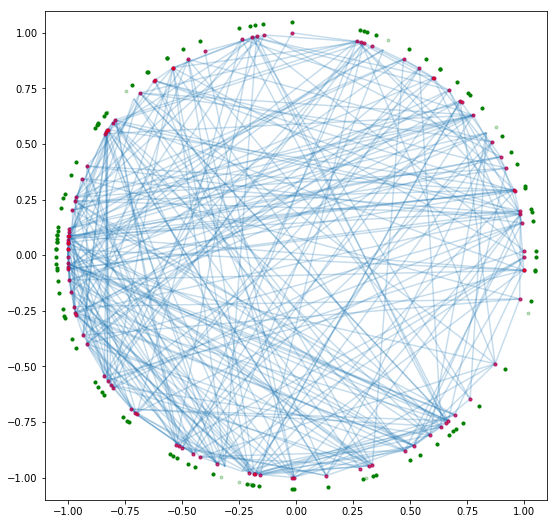

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9)

def init():
    good = pattern.nonzero()[0]
    ax.plot(np.cos(good), np.sin(good), 'g.', alpha=0.25)
    
    lines = []
    lc = collections.LineCollection(lines, alpha=0.25)
    ax.add_collection(lc)
    
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.margins(0.1)
    return (lc,)

#Define the animation function, which is called for each new frame:

def animate(i):
    # state is what created _inter
    _inter, state = inters[i]
    connections = W_J.multiply(state)
    rows, cols = connections.nonzero()
    
    lines = [[(np.cos(c),np.sin(c)), (np.cos(r),np.sin(r))] for r, c in zip(rows, cols)]
    lc = collections.LineCollection(lines, alpha=0.25)
    
    ax.clear()
    ax.add_collection(lc)
    
    start = state.nonzero()[0]
    ax.plot(np.cos(start), np.sin(start), 'b.', alpha=0.5)
    
    end = _inter.nonzero()[0]
    ax.plot(np.cos(end), np.sin(end), 'r.', alpha=0.5)
    
    
    good = pattern.nonzero()[0]
    ax.plot(1.05*np.cos(good), 1.05*np.sin(good), 'g.', alpha=0.25)
    
    lit = list(set(good) & set(start))
    ax.plot(1.05*np.cos(lit), 1.05*np.sin(lit), 'g.', alpha=1)
    
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.margins(0.1)
    return (lc,)

#Compile the animation. Setting blit=True will only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(inters), interval=500, 
                               blit=True)

HTML(anim.to_jshtml())